In [2]:
!pip install transformers
# !pip install sentencepiece

In [3]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
data = pd.read_json('/kaggle/input/data-coursework/News_Category_Dataset_v3.json', lines=True)
data.head(2)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23


In [5]:
data['content'] = data.headline + ' ' + data.short_description
labels = data.category

In [6]:
data.drop(['authors','link','date', 'headline', 'short_description'], axis=1, inplace=True)

In [7]:
text = data.content
labels = data.category

In [8]:
labels.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [9]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(text, labels,
random_state=42,test_size=0.20, stratify=labels)

In [10]:
# test_inputs, validation_inputs, test_labels, validation_labels = train_test_split(test_inputs, test_labels,
# random_state=42,test_size=0.50, stratify=test_labels)

In [11]:
train = pd.concat([train_inputs, train_labels], sort=False, axis=1)
test = pd.concat([test_inputs, test_labels], sort=False, axis=1)

In [12]:
for i in ['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE']:
    train[i] = train['category'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['category'].apply(lambda x: 1 if i in x else 0)

In [13]:
train.drop(['category'], axis=1, inplace=True)
test.drop(['category'], axis=1, inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [14]:
train.head(2)

,content,U.S. NEWS,COMEDY,PARENTING,WORLD NEWS,CULTURE & ARTS,TECH,SPORTS,ENTERTAINMENT,POLITICS,...,STYLE,GREEN,TASTE,HEALTHY LIVING,THE WORLDPOST,GOOD NEWS,WORLDPOST,FIFTY,ARTS,DIVORCE
0,The Last Letter: Coming Out To My Late Father ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"In Fatal Shootings By Police, 1 In 5 Officers'...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [17]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

['U.S. NEWS',
 'COMEDY',
 'PARENTING',
 'WORLD NEWS',
 'CULTURE & ARTS',
 'TECH',
 'SPORTS',
 'ENTERTAINMENT',
 'POLITICS',
 'WEIRD NEWS',
 'ENVIRONMENT',
 'EDUCATION',
 'CRIME',
 'SCIENCE',
 'WELLNESS',
 'BUSINESS',
 'STYLE & BEAUTY',
 'FOOD & DRINK',
 'MEDIA',
 'QUEER VOICES',
 'HOME & LIVING',
 'WOMEN',
 'BLACK VOICES',
 'TRAVEL',
 'MONEY',
 'RELIGION',
 'LATINO VOICES',
 'IMPACT',
 'WEDDINGS',
 'COLLEGE',
 'PARENTS',
 'ARTS & CULTURE',
 'STYLE',
 'GREEN',
 'TASTE',
 'HEALTHY LIVING',
 'THE WORLDPOST',
 'GOOD NEWS',
 'WORLDPOST',
 'FIFTY',
 'ARTS',
 'DIVORCE']

In [18]:
len(target_cols)

42

In [19]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [20]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [22]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # self.roberta = AutoModel.from_pretrained('xlm-roberta-base')
        self.roberta = AutoModel.from_pretrained('roberta-base')
        # self.albert = AlbertModel.from_pretrained('')
        # self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, 42)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        # _, features = self.albert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
      # print(data)
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%1500 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [25]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.707324206829071
Epoch: 0, Loss:  0.07076513022184372
Epoch: 0, Loss:  0.06973957270383835
Epoch: 0, Loss:  0.03712176904082298
Epoch: 1, Loss:  0.0373217798769474
Epoch: 1, Loss:  0.047466620802879333
Epoch: 1, Loss:  0.03275348246097565
Epoch: 1, Loss:  0.05485817417502403
Epoch: 2, Loss:  0.03480294719338417
Epoch: 2, Loss:  0.03755052387714386
Epoch: 2, Loss:  0.0244152769446373
Epoch: 2, Loss:  0.028198067098855972


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 2
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.6889464855194092

Epoch: 0, Loss:  0.07496049255132675

Epoch: 0, Loss:  0.052989374846220016

Epoch: 0, Loss:  0.05867699906229973

Epoch: 0, Loss:  0.05216612294316292

Epoch: 0, Loss:  0.04868490993976593

Epoch: 1, Loss:  0.04212147742509842

Epoch: 1, Loss:  0.02895505726337433

Epoch: 1, Loss:  0.04160383716225624

Epoch: 1, Loss:  0.02645977959036827

Epoch: 1, Loss:  0.04306882619857788

Epoch: 1, Loss:  0.023577414453029633


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.7035199999809265

Epoch: 0, Loss:  0.07008205354213715

Epoch: 0, Loss:  0.05458378791809082

Epoch: 0, Loss:  0.046902742236852646

Epoch: 0, Loss:  0.04084315896034241

Epoch: 0, Loss:  0.03287513554096222

Epoch: 1, Loss:  0.048614393919706345

Epoch: 1, Loss:  0.035894133150577545

Epoch: 1, Loss:  0.04114349186420441

Epoch: 1, Loss:  0.03445537015795708

Epoch: 1, Loss:  0.041035983711481094

Epoch: 1, Loss:  0.03298289701342583

Epoch: 2, Loss:  0.03249156102538109

Epoch: 2, Loss:  0.01597142592072487

Epoch: 2, Loss:  0.023408446460962296

Epoch: 2, Loss:  0.04140589386224747

Epoch: 2, Loss:  0.028972750529646873

Epoch: 2, Loss:  0.025964884087443352


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 64
# VALID_BATCH_SIZE = 64
# EPOCHS = 2
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.6965194344520569

Epoch: 0, Loss:  0.06367406249046326

Epoch: 0, Loss:  0.051663514226675034

Epoch: 1, Loss:  0.04521160572767258

Epoch: 1, Loss:  0.04024066403508186

Epoch: 1, Loss:  0.033763203769922256


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 64
# VALID_BATCH_SIZE = 64
# EPOCHS = 2+1
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.0404331237077713

Epoch: 0, Loss:  0.03979886323213577

Epoch: 0, Loss:  0.03397054597735405


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 16
# VALID_BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.679154098033905

Epoch: 0, Loss:  0.06287044286727905

Epoch: 0, Loss:  0.042318109422922134

Epoch: 0, Loss:  0.04791518300771713

Epoch: 0, Loss:  0.0666065514087677

Epoch: 0, Loss:  0.04809458181262016

Epoch: 0, Loss:  0.02312854491174221

Epoch: 1, Loss:  0.05501330643892288

Epoch: 1, Loss:  0.052601225674152374

Epoch: 1, Loss:  0.06230046600103378

Epoch: 1, Loss:  0.05588172376155853

Epoch: 1, Loss:  0.02176370471715927

Epoch: 1, Loss:  0.038893554359674454


In [26]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [28]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5

from sklearn import metrics

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6563499260249129
F1 Score (Micro) = 0.7200114446484347
F1 Score (Macro) = 0.6255083522648535


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 2
# LEARNING_RATE = 2e-5

from sklearn import metrics

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6484035698945259

F1 Score (Micro) = 0.717367866358163

F1 Score (Macro) = 0.6015719697559267


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3 + 2.5
# LEARNING_RATE = 2e-5

from sklearn import metrics

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6841741039469288

F1 Score (Micro) = 0.727081673421785

F1 Score (Macro) = 0.633157489728572


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5

from sklearn import metrics

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6720994606977521

F1 Score (Micro) = 0.7319807354897967

F1 Score (Macro) = 0.6289294361415756


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 1,5
# LEARNING_RATE = 2e-5

from sklearn import metrics

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6330358421228464

F1 Score (Micro) = 0.7052857280524236

F1 Score (Macro) = 0.5629521236835127


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 64
# VALID_BATCH_SIZE = 64
# EPOCHS = 2
# LEARNING_RATE = 2e-5


outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6358039421562545

F1 Score (Micro) = 0.7101777453128804

F1 Score (Macro) = 0.564147352219536


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 64
# VALID_BATCH_SIZE = 64
# EPOCHS = 2+1
# LEARNING_RATE = 2e-5

outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6667303011501933

F1 Score (Micro) = 0.7246155680057219

F1 Score (Macro) = 0.6075343688737687


In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 16
# VALID_BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

In [ ]:
def confusion_m():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = test()

In [ ]:
new_targets = []
for each in targets:
  tar = []
  for i in range(1, 43, 1):
    # print(each[i] * i)
    tar.append(int(each[i - 1] * (i)))
  new_targets.append(max(tar))

In [ ]:
new_outputs = []
for each in outputs:
  tar = []
  for i in range(1, 43, 1):
    # print(each[i] * i)
    tar.append(int(each[i - 1] * (i)))
  if (max(tar)==0):
    new_outputs.append(random.randint(1, 43))
  else:
    new_outputs.append(max(tar))

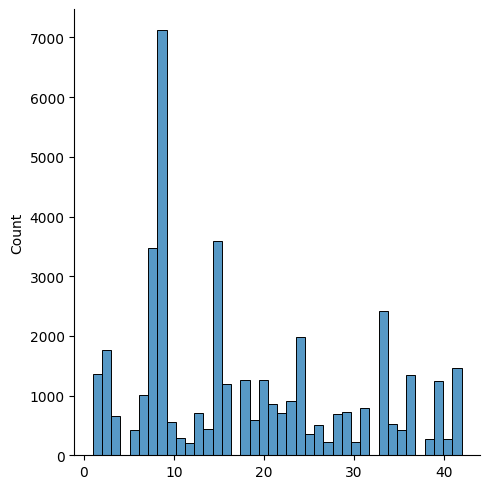

In [ ]:
sns.displot(new_targets)

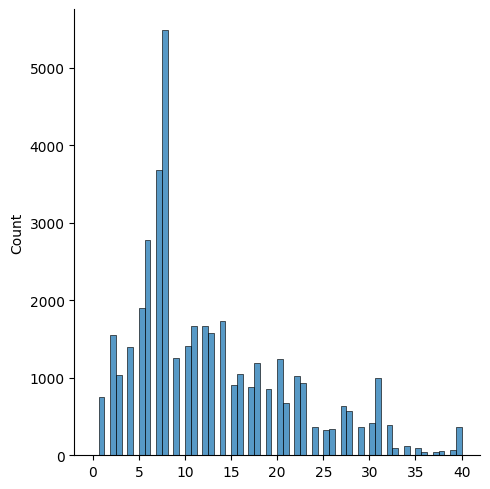

In [ ]:
sns.displot(new_outputs)

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

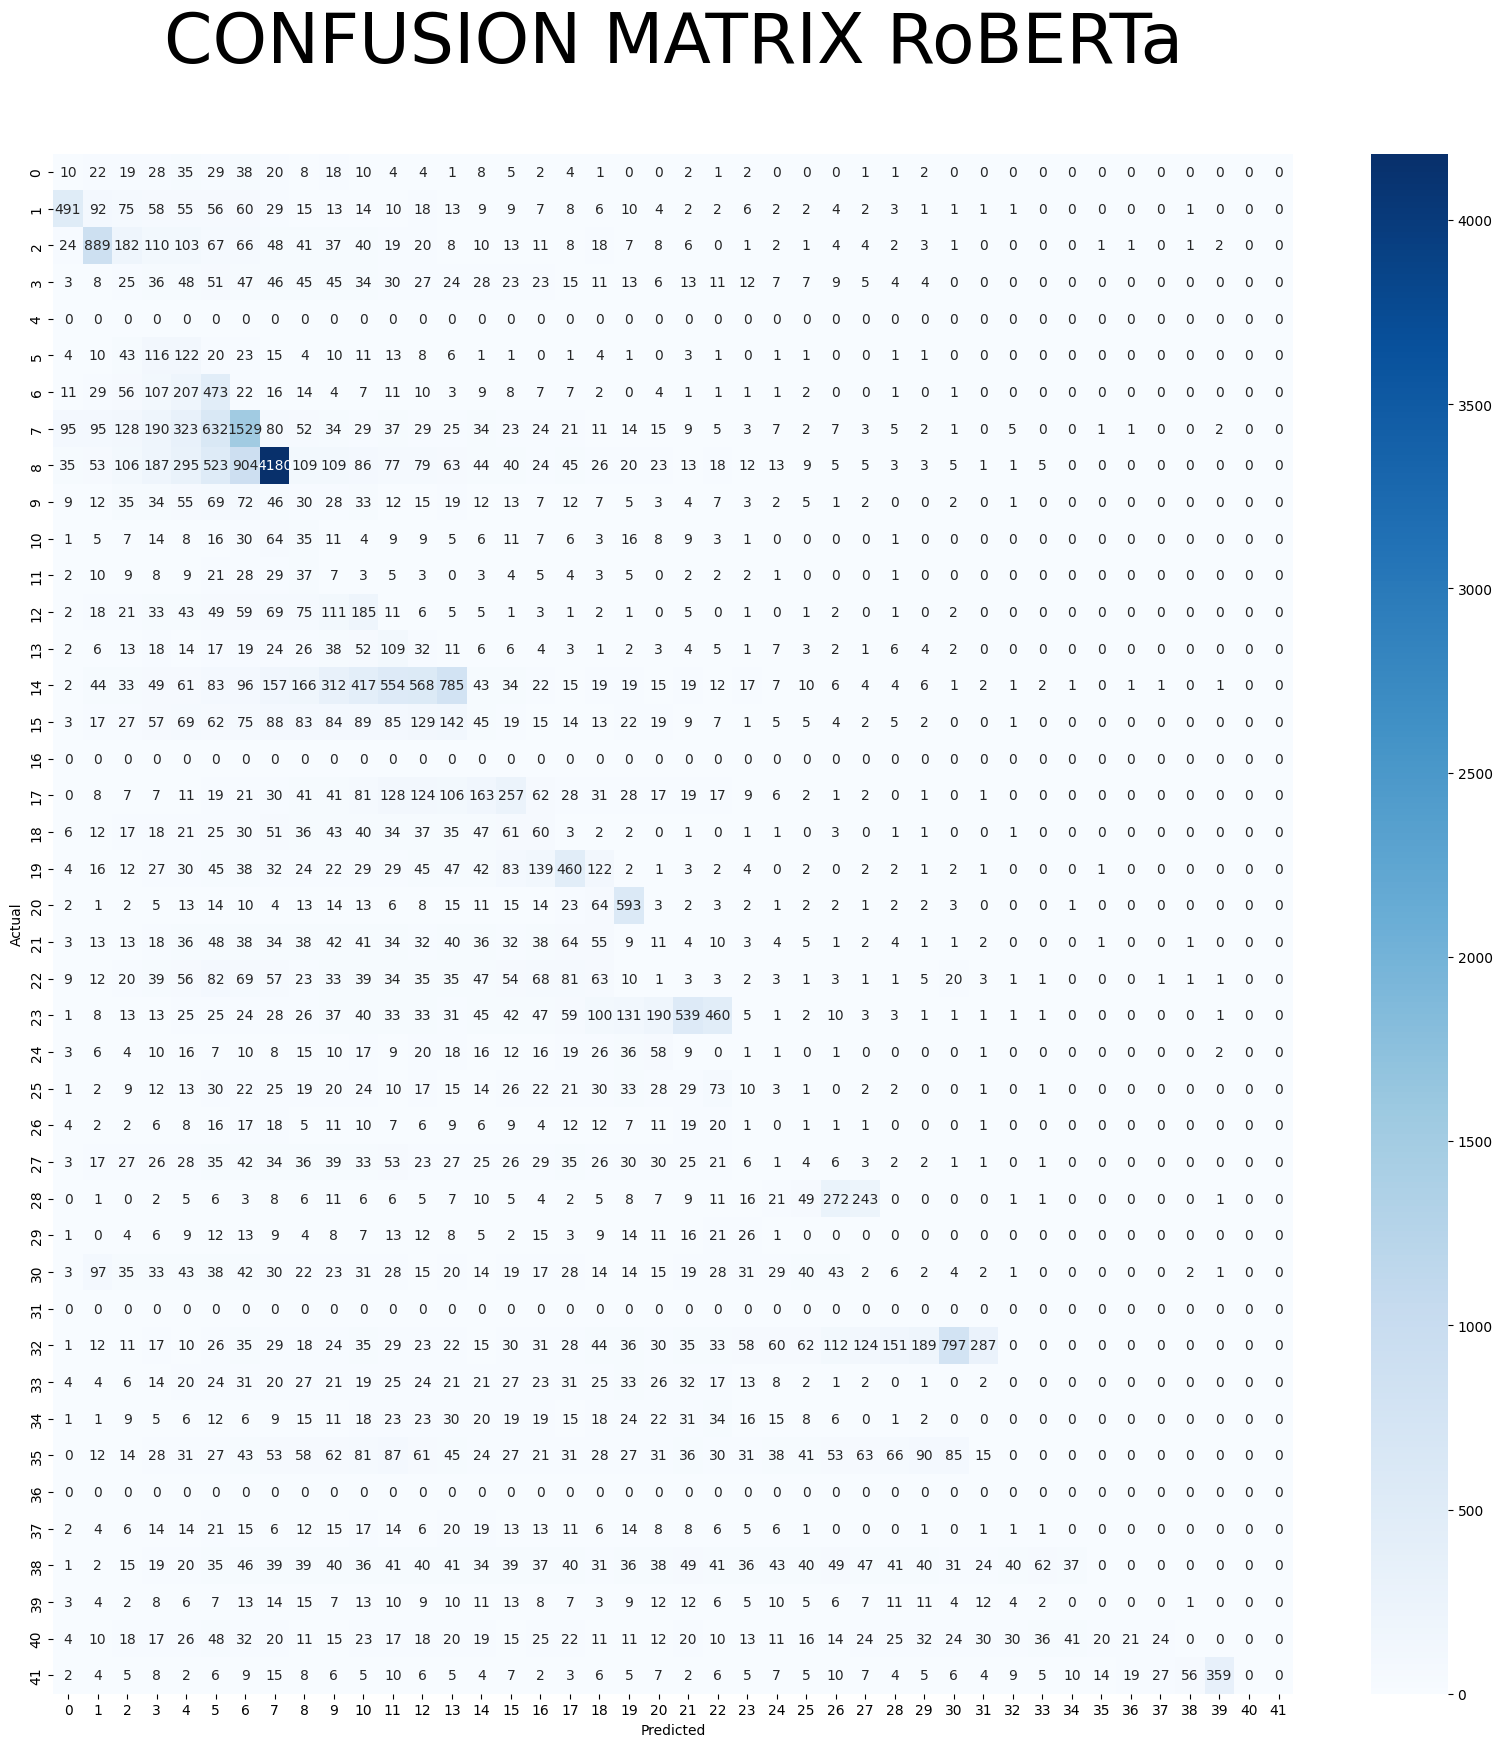

In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 2
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [33]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [34]:
train_outputs, train_targets = test_model_by_train()

In [ ]:
train_outputs

In [30]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7692413241777581
F1 Score (Micro) = 0.8275932819415541
F1 Score (Macro) = 0.7568701575332125


In [36]:
from scipy.special import softmax

new_outputs = softmax(train_outputs)

In [39]:
new_targets = []
for each in train_targets:
  tar = []
  for i in range(0, 42, 1):
    # print(each[i] * i)
    tar.append(int(each[i] * (i)))
  new_targets.append(max(tar))

In [43]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)

LinearSVC(C=0.5, class_weight='balanced', max_iter=100000, random_state=42)

In [46]:
test_outputs, test_targets = test()
y_pred = clf.predict(test_outputs)

In [47]:
test_labels = []
for each in test_targets:
  tar = []
  for i in range(0, 42, 1):
    # print(each[i] * i)
    tar.append(int(each[i] * (i)))
  test_labels.append(max(tar))

In [48]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7141459456879683
F1 Score (Micro) = 0.7141459456879683
F1 Score (Macro) = 0.6356731443040807


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

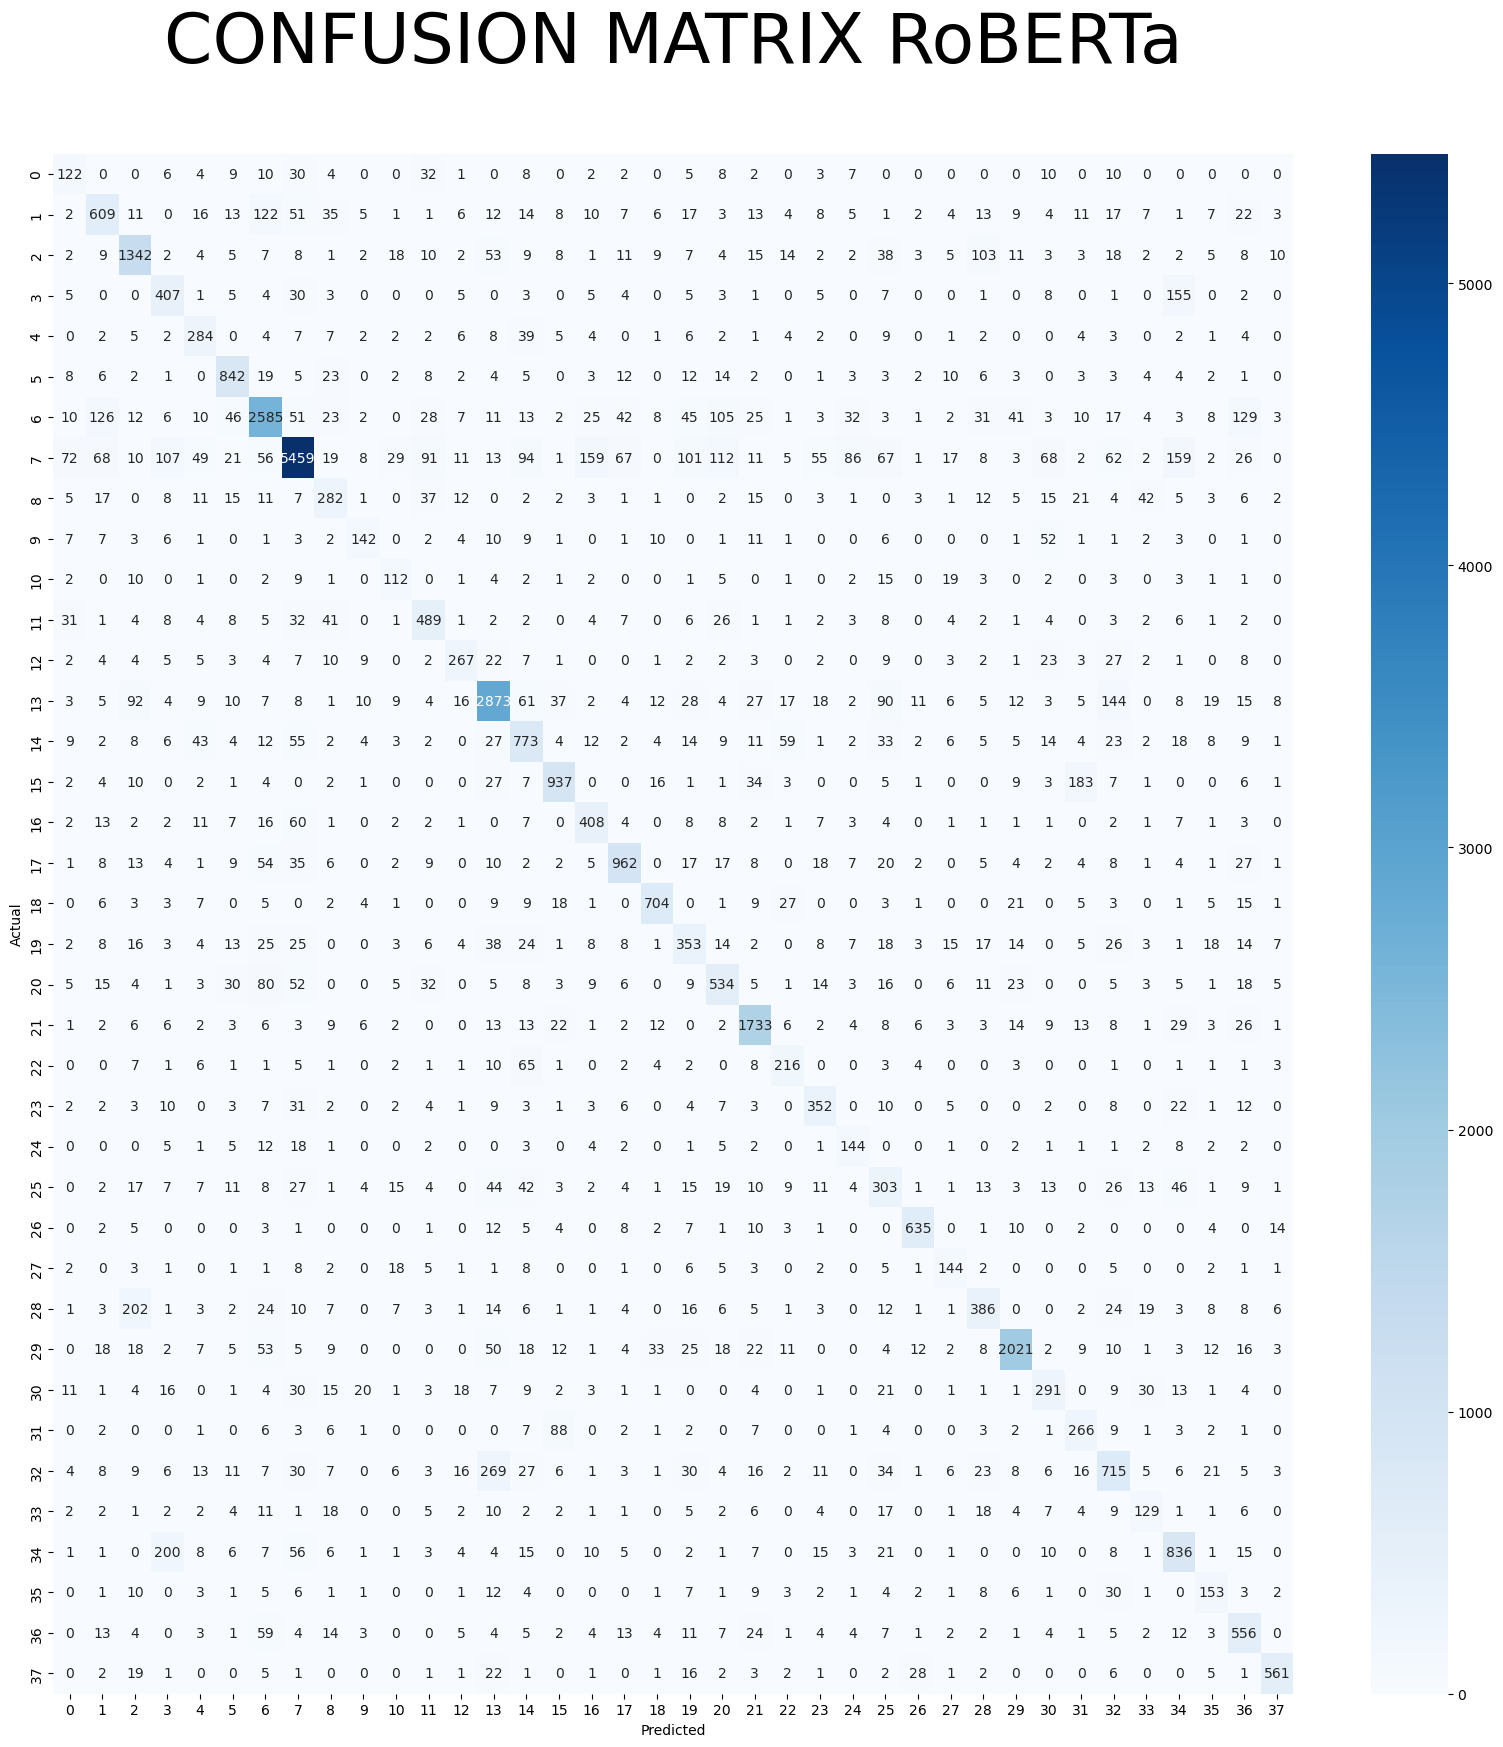

In [49]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
# + linearSVC(c = 0.5)
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [50]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.44      0.41       275
           1       0.63      0.56      0.59      1080
           2       0.72      0.76      0.74      1758
           3       0.49      0.62      0.54       660
           5       0.54      0.67      0.60       421
           6       0.77      0.83      0.80      1015
           7       0.79      0.74      0.77      3473
           8       0.88      0.77      0.82      7121
           9       0.50      0.51      0.50       555
          10       0.63      0.49      0.55       289
          11       0.46      0.55      0.50       203
          12       0.62      0.69      0.65       712
          13       0.67      0.61      0.64       441
          14       0.80      0.80      0.80      3589
          15       0.58      0.65      0.61      1198
          17       0.80      0.74      0.77      1268
          18       0.59      0.69      0.64       589
          19       0.80    

In [52]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [53]:
y_pred = clf.predict(test_outputs)

In [54]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7056984679998091
F1 Score (Micro) = 0.7056984679998091
F1 Score (Macro) = 0.630315628089397


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

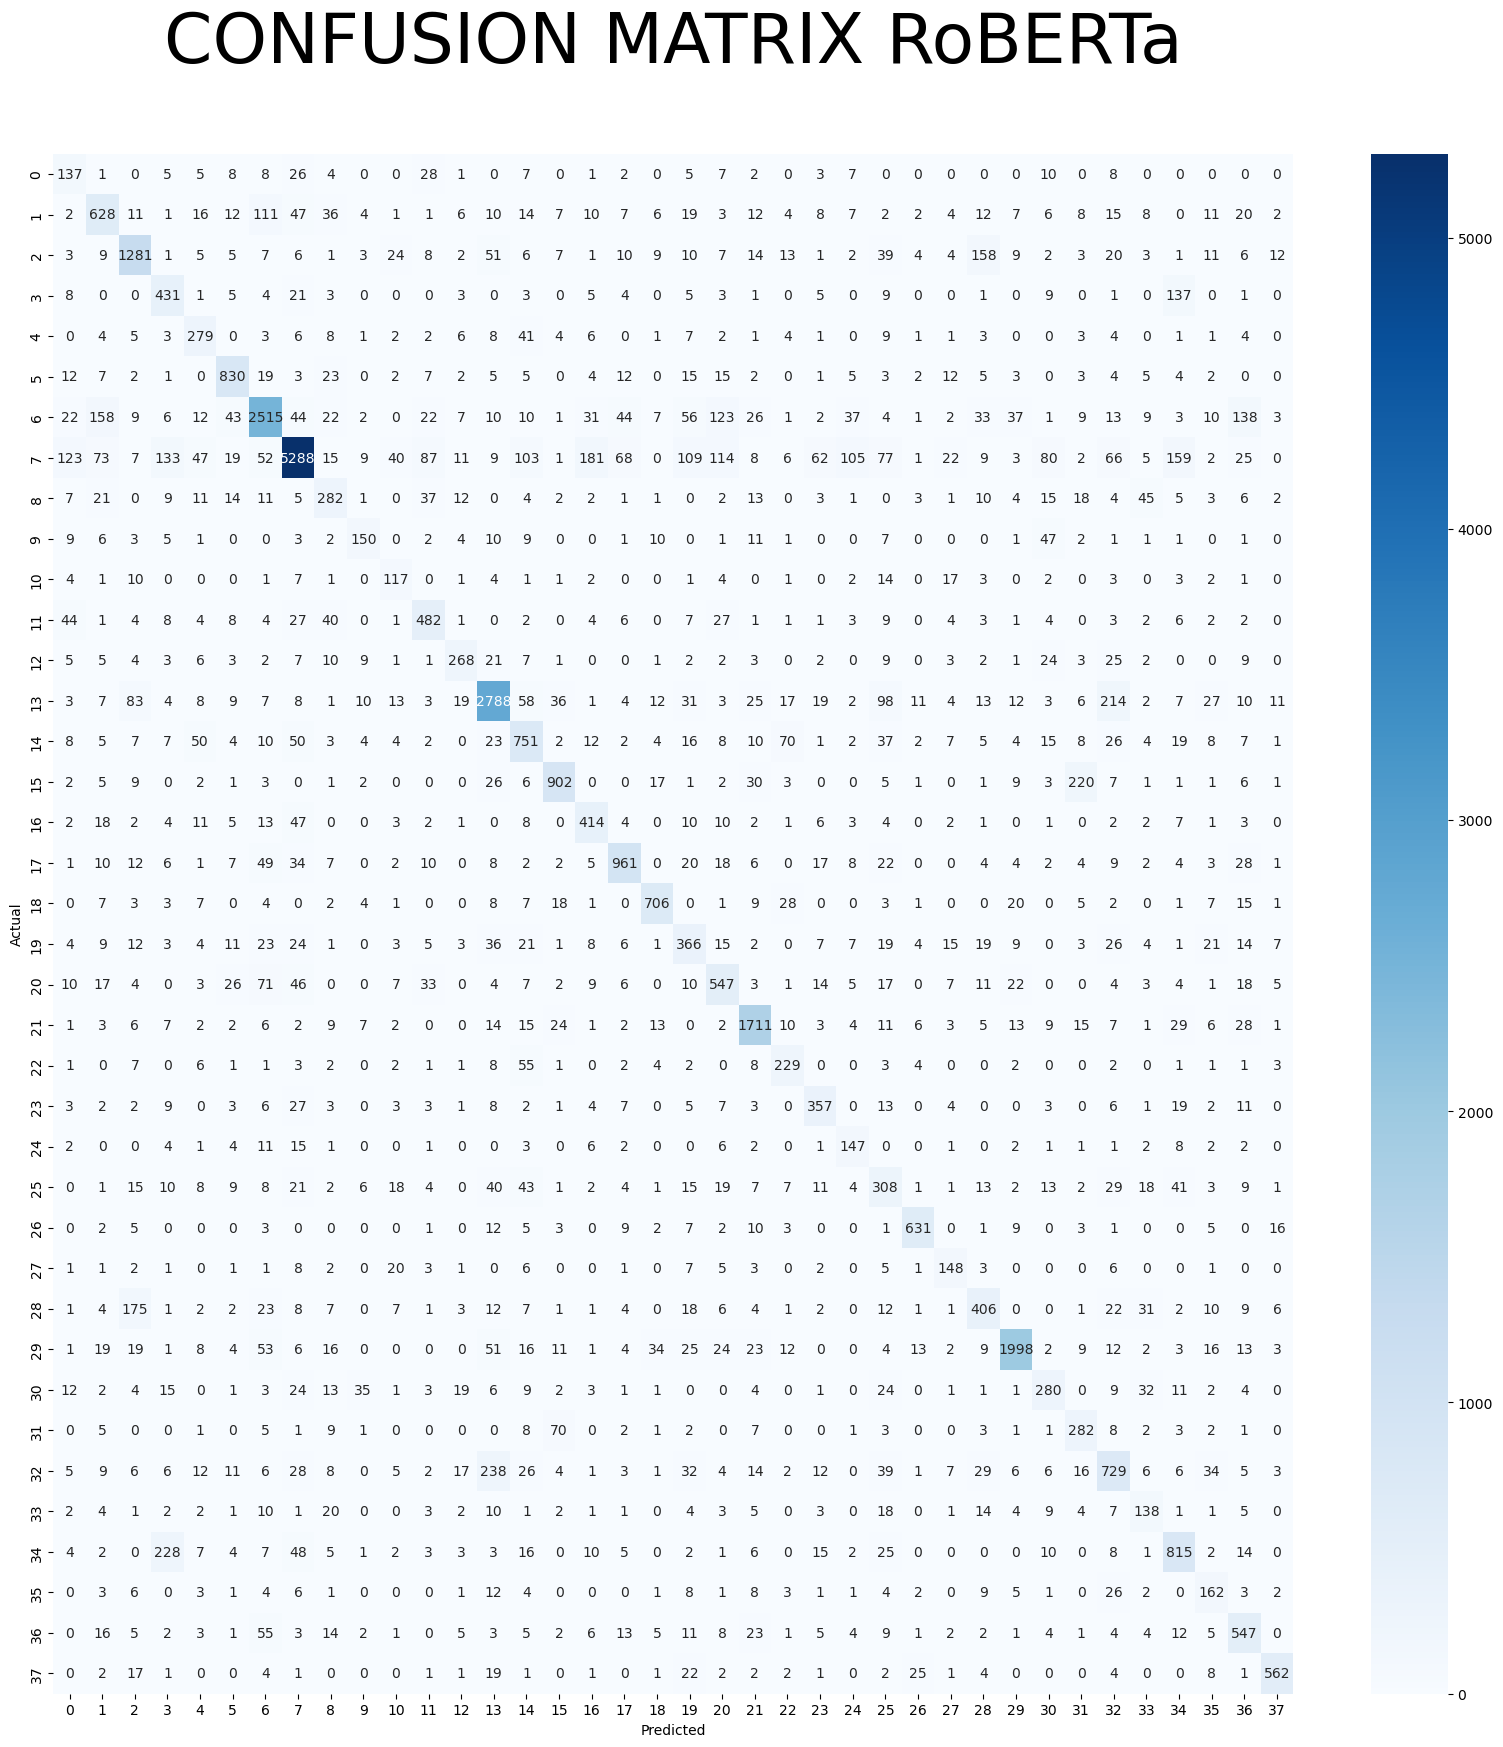

In [55]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
# + LogisticRegression(c = 0.5)
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [56]:
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.50      0.38       275
           1       0.59      0.58      0.59      1080
           2       0.74      0.73      0.73      1758
           3       0.47      0.65      0.55       660
           5       0.53      0.66      0.59       421
           6       0.79      0.82      0.80      1015
           7       0.81      0.72      0.76      3473
           8       0.90      0.74      0.81      7121
           9       0.49      0.51      0.50       555
          10       0.60      0.52      0.56       289
          11       0.41      0.58      0.48       203
          12       0.64      0.68      0.66       712
          13       0.67      0.61      0.64       441
          14       0.81      0.78      0.79      3589
          15       0.58      0.63      0.60      1198
          17       0.81      0.71      0.76      1268
          18       0.56      0.70      0.63       589
          19       0.80    

In [57]:
clf = LinearSVC(C=1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7141936715506133
F1 Score (Micro) = 0.7141936715506133
F1 Score (Macro) = 0.6357650019096809


In [1]:
clf = LinearSVC(C=10, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

NameError: name 'LinearSVC' is not defined